# Generate surrogate data and simulate neuron spiking.

In this file, we generate surrogate data and simulating neuron spiking process to get ground turth for following experiments.

## Generate neural arrays and generation of sets of random assemblies
    1. Generate a hexagonal lattice of unit spacing, in which a neuron was placed at every lattice point.
    2. Draw points to get an assembly by:
        (1) Random generate points.
        (2) Calculate closest neural
        (3) If the distance smaller than a throshold, get that neural into assemblies.
    3.  Repeat 2 to get multiple assemblies.
    

In [177]:
from coniii import *
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import random

In [178]:
# define parameters
T = 3600 # time of simulation
N = 81  # number of neurons
dT = 0.5 # time step
params_assembly_density = 4 # size of neurons in each assembly
params_assembly_num = 10 # number of assemblies
params_point_into_neuron_distance = 0.5
fire_rate_background = np.random.uniform(1, 6, N)

In [179]:
# Function to create a neuron array using unit-spacing hexagonal lattice points
def create_neuron_array(num_neurons):
    coords = []
    num_rows = int(np.sqrt(num_neurons))
    num_cols = num_rows
    for i in range(num_rows):
        for j in range(num_cols):
            x = j + 0.5 * (i % 2)  # Stagger every other row to create hexagonal pattern
            y = i * np.sqrt(3) / 2  # Scale row spacing by sqrt(3)/2 to create hexagonal pattern
            coords.append((x, y))
    return np.array(coords)

In [180]:
# Function to create an assembly of neurons
def create_assembly(neuron_coords, num_points, mean, std_dev):
    # Create the covariance matrix
    cov_matrix = np.eye(2) * std_dev**2
    # Draw points from a two-dimensional normal distribution
    points = np.random.multivariate_normal(mean, cov_matrix, num_points)
    # Find the closest neuron to each drawn point
    distances = cdist(points, neuron_coords)
    closest_neurons = np.argmin(distances, axis=1)
    # If the distance from the neuron to the drawn point is less than 0.5, it is considered part of the assembly
    assembly_neurons = neuron_coords[closest_neurons[distances[np.arange(len(closest_neurons)), closest_neurons] < 0.5]]
    print("Number of neurons in assembly: ", len(assembly_neurons))
    print("Neurons in assembly:\n ", assembly_neurons)
    return assembly_neurons

Number of neurons in assembly:  4
Neurons in assembly:
  [[7.         1.73205081]
 [5.5        2.59807621]
 [6.         3.46410162]
 [5.5        2.59807621]]
Number of neurons in assembly:  4
Neurons in assembly:
  [[1.         1.73205081]
 [1.5        2.59807621]
 [1.         1.73205081]
 [1.5        0.8660254 ]]
Number of neurons in assembly:  1
Neurons in assembly:
  [[4.         6.92820323]]
Number of neurons in assembly:  1
Neurons in assembly:
  [[0. 0.]]
Number of neurons in assembly:  3
Neurons in assembly:
  [[0.5        2.59807621]
 [2.         5.19615242]
 [0.5        4.33012702]]
Number of neurons in assembly:  2
Neurons in assembly:
  [[8.         5.19615242]
 [8.         3.46410162]]
Number of neurons in assembly:  4
Neurons in assembly:
  [[3.         3.46410162]
 [1.5        6.06217783]
 [1.5        4.33012702]
 [2.         3.46410162]]
Number of neurons in assembly:  3
Neurons in assembly:
  [[3.5        6.06217783]
 [4.         6.92820323]
 [2.         6.92820323]]
Nu

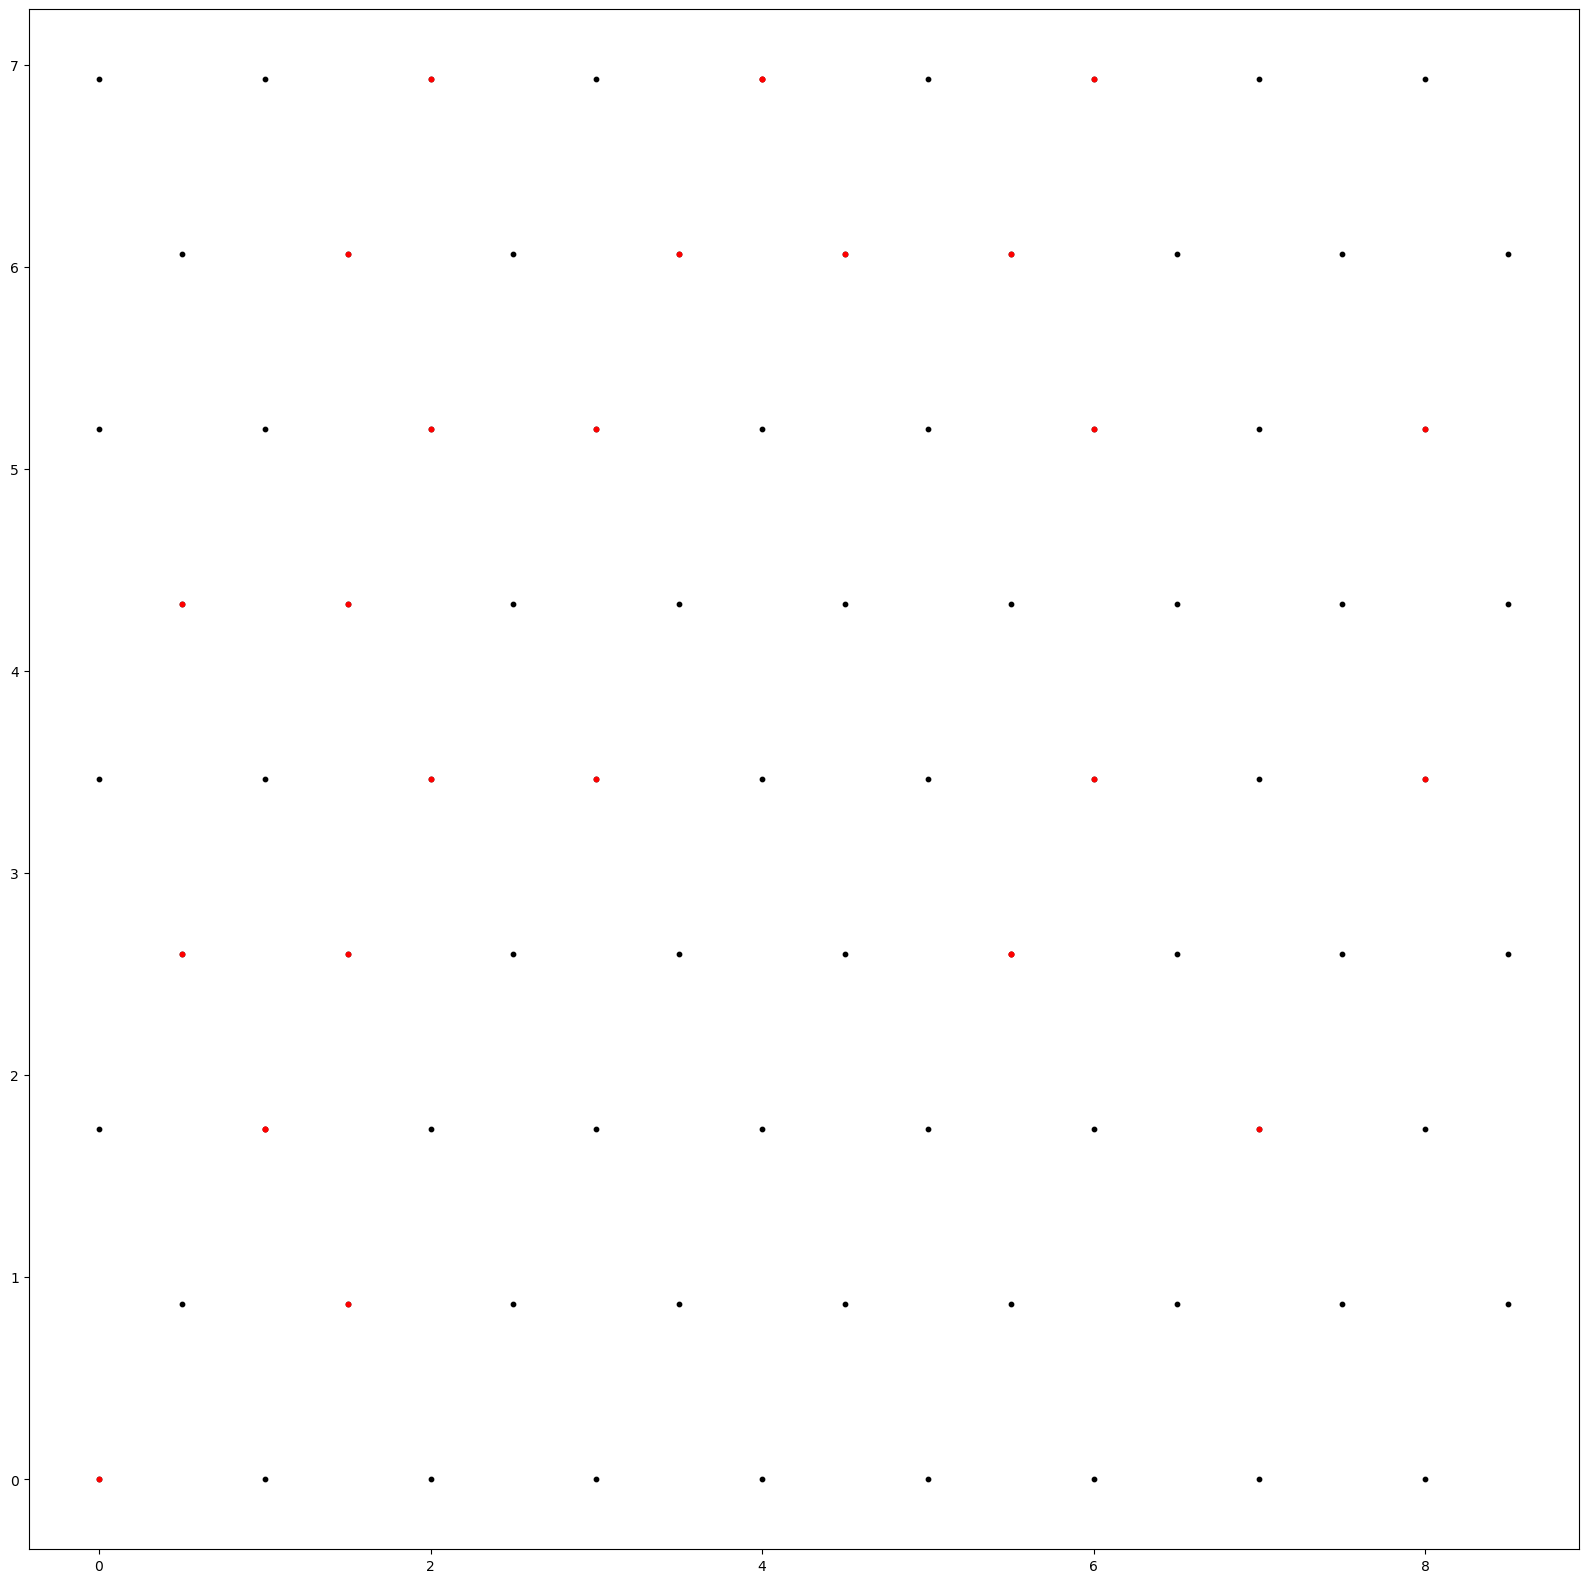

In [181]:


# Generate the neuron array
neuron_array = create_neuron_array(N)


# Generate assemblies
assemblies = []
for i in range(params_assembly_num):
    # Choose a centre from a uniform distribution
    params_distruibution_centre = np.random.uniform(0, 8, size=2)
    # Choose a standard deviation from a uniform distribution
    params_distribution_std_dev = np.random.uniform(3.5, 4.5, size=2)
    assembly = create_assembly(neuron_array,params_assembly_density ,params_distruibution_centre, 1)
    assemblies.append(assembly)

# Plot the neuron array and assemblies
plt.figure(figsize=(20, 20))
plt.scatter(neuron_array[:, 0], neuron_array[:, 1], color='black', s=10)
for assembly in assemblies:
    plt.scatter(assembly[:, 0], assembly[:, 1], color='red', s=10)
plt.show()



## Simulation of population calcium fluorescence activity

### Assign firing rate for each neuron
    1. Every neuron have a background firing rate independently and uniformly from range R
    2. At each time t, every neuron n had a probability 


In [182]:
# First, generate a dictionary mapping neuron coordinates to indices
coord_to_index = {tuple(coord): i for i, coord in enumerate(neuron_array)}

neuron_array_coord = neuron_array
assemblies_coord = assemblies

# Then, replace the coordinates in the neuron_array with indices
neuron_array = np.array([coord_to_index[tuple(coord)] for coord in neuron_array_coord])



# Finally, replace the coordinates in the assemblies with indices
for i in range(len(assemblies)):
    assemblies[i] = [coord_to_index[tuple(coord)] for coord in assemblies_coord[i] if tuple(coord) in coord_to_index]

print("Neuron array: ", neuron_array)
print("Assemblies: ", assemblies)

Neuron array:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80]
Assemblies:  [[25, 32, 42, 32], [19, 28, 19, 10], [76], [0], [27, 56, 45], [62, 44], [39, 64, 46, 38], [66, 76, 74], [60, 68, 67, 78], [57]]


In [183]:
import numpy as np
from scipy.stats import poisson

def generateSpikeCountField(N, T, dT, assemblies, rateRange, eventDur, eventProb, eventMult):
    
    """
    Function to generate spike count for a given set of parameters.
    N: Number of neurons
    T: Number of time steps
    dT: Width of a time step in units of seconds
    assemblies: List of collections of units to be combined to assemblies
    rateRange: Range of base firing rate in units of inverse seconds (Hertz)
    eventDur: Length of an active event as a number of timesteps
    eventProb: Probability with which a unit is particularly active in a single timestep
    eventMult: Firing rate multiplier at active events
    """
    
    # Initialization
    fire_rate_background = np.random.uniform(rateRange[0], rateRange[1], size=(T, N))
    activation_field = np.zeros((T, N), dtype=bool)

    # Generate activation for each assembly and each neuron
    for t in range(T):
        for assembly in assemblies:
            # If any neuron in this assembly is activated, all neurons in this assembly are activated
            if np.any(np.random.rand(len(assembly)) < eventProb):
                activation_field[t, assembly] = True
        # For neurons not in any assembly, they are activated independently
        not_in_assembly = np.setdiff1d(np.arange(N), np.concatenate(assemblies))
        activation_field[t, not_in_assembly] = np.random.rand(len(not_in_assembly)) < eventProb

    # If neuron is activated at a timestep, its firing rate is increased by eventMult times
    fire_rate = np.where(activation_field, fire_rate_background * eventMult, fire_rate_background)
    # Generate Poisson spike count for each neuron at each timestep
    spike_count = np.random.poisson(fire_rate * dT)
    
    return spike_count


In [184]:
import csv
# Length of an active event as a number of timesteps
eventDur = np.random.randint(1, 10)

# Probability with which a unit is particularly active in a single timestep
eventProb = np.random.uniform(0.01, 0.05)

# Firing rate multiplier at active events
eventMult = np.random.uniform(6, 10)  # random number between 1 and 5

print(f'eventDur: {eventDur}, eventProb: {eventProb}, eventMult: {eventMult}')

spikeCount = generateSpikeCountField(N, T, dT, assemblies, (1, 6), eventDur, eventProb, eventMult)

csvfile = open('spikeCount.csv', 'w')
writer = csv.writer(csvfile)
writer.writerows(spikeCount)

print(spikeCount.shape)
print(spikeCount)

eventDur: 8, eventProb: 0.029774599880058438, eventMult: 8.217687453145095
(3600, 81)
[[3 0 2 ... 2 1 0]
 [0 2 0 ... 2 2 0]
 [1 0 0 ... 5 2 2]
 ...
 [0 3 1 ... 0 2 4]
 [0 6 1 ... 6 1 0]
 [0 3 3 ... 1 0 0]]


In [185]:
for assembly in assemblies:
    print(assembly)
    print(np.random.rand(len(assembly)))
    print(np.random.rand(len(assembly)) < eventProb)

[25, 32, 42, 32]
[0.10192006 0.20521674 0.12844532 0.14512406]
[False False False False]
[19, 28, 19, 10]
[0.30593911 0.5805218  0.52237824 0.76510609]
[False False  True False]
[76]
[0.37862271]
[False]
[0]
[0.98868858]
[False]
[27, 56, 45]
[0.15760136 0.65710886 0.7638532 ]
[False False False]
[62, 44]
[0.40897654 0.38676082]
[False False]
[39, 64, 46, 38]
[0.43249641 0.37913341 0.15926609 0.75899601]
[False False False False]
[66, 76, 74]
[0.68753283 0.13241988 0.91096948]
[False False False]
[60, 68, 67, 78]
[0.28416051 0.51283899 0.76843822 0.87547975]
[False False False False]
[57]
[0.78304037]
[False]
